# Imports

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as df
#from dask_ml.impute import SimpleImputer
#from dask_ml.xgboost import XGBClassifier
#from dask_ml.preprocessing import LabelEncoder
#from dask_ml.model_selection import KFold
#from dask_ml.linear_model import LogisticRegression
from dask.distributed import Client, LocalCluster
from dask import compute
from xgboost import XGBClassifier
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, precision_score, f1_score, precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import ttest_ind, ttest_rel
from collections import namedtuple
from recordtype import recordtype

sns.set(style="darkgrid")
numpy.set_printoptions(suppress=True)
#numpy.seterr(divide='ignore', invalid='ignore')

In [2]:
SEED = 0
JOBS = 10

In [5]:
cluster = LocalCluster(n_workers=JOBS)
client = Client(cluster)

# Data Exploration

In [6]:
data = df.read_csv('./data/train_transaction.csv', header=0).set_index('TransactionID')

In [5]:
data.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 393 entries, isFraud to V339
dtypes: object(14), float64(376), int64(3)

In [7]:
data['isFraud'].value_counts().compute()

0    569877
1     20663
Name: isFraud, dtype: int64

From the table we can see that we are dealing with an imbalanced dataset.

## Missing Values

In [56]:
data.loc[:, 'TransactionAmt': 'M9'].isnull().sum().compute()

TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
D2                280797
D3                262878
D4                168922
D5                309841
D6                517353
D7                551623
D8                515614
D9                515614
D10                76022
D11               279287
D12               525823


In [7]:
sample_pos = data[data['isFraud']==1]
sample_neg = data[data['isFraud']==0].sample(frac=0.05, random_state=SEED)

In [9]:
sample = df.concat([sample_pos, sample_neg]).compute()

In [ ]:
sample.to_csv('./data/sample.csv', header=True, idnex=True)

In [3]:
types = {'TransactionAmt': 'float32', 'ProductCD': 'category', 'card1': 'float32', 'card2': 'float32', 'card3': 'float32', 'card4': 'category', 'card5': 'float32', 'card6': 'category'}
types.update({f'C{i}': 'float32' for i in range(1,15)})
types.update({f'M{i}': 'category' for i in range(1,10)})
types.update({f'D{i}': 'float32' for i in range(1,16)})
types.update({'addr1': 'float32', 'addr2': 'float32', 'dist1': 'float32', 'dist2': 'float32', 'P_emaildomain': 'category', 'R_emaildomain': 'category'})
types.update({f'V{i}': 'float32' for i in range(1, 340)})

In [4]:
data = pandas.read_csv('./data/sample.csv', header=0, dtype=types).set_index('TransactionID')

In [5]:
data.drop(columns=['TransactionDT'], inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49156 entries, 2987203 to 3544102
Columns: 392 entries, isFraud to V339
dtypes: category(14), float32(377), int64(1)
memory usage: 72.1 MB


In [7]:
y = data['isFraud']
X = data.drop(columns=['isFraud'])
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,W,18268.0,583.0,150.0,visa,226.0,credit,251.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987240,37.098000,C,13413.0,103.0,185.0,visa,137.0,credit,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987243,37.098000,C,13413.0,103.0,185.0,visa,137.0,credit,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987245,37.098000,C,13413.0,103.0,185.0,visa,137.0,credit,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987288,155.520996,C,16578.0,545.0,185.0,visa,226.0,credit,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
y.value_counts()

0    28493
1    20663
Name: isFraud, dtype: int64

In [9]:
mean_imp = SimpleImputer(strategy='mean')
mode_imp = SimpleImputer(strategy='most_frequent')

In [10]:
X[['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2']] = mean_imp.fit_transform(X[['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2']])
X[['card4', 'card6', 'P_emaildomain', 'R_emaildomain']] = mode_imp.fit_transform(X[['card4', 'card6', 'P_emaildomain', 'R_emaildomain']])
X[[f'M{i}' for i in range(1,10)]] = mode_imp.fit_transform(X[[f'M{i}' for i in range(1,10)]])
X[[f'D{i}' for i in range(1,16)]] = mean_imp.fit_transform(X[[f'D{i}' for i in range(1,16)]])
X[[f'V{i}' for i in range(1,340)]] = mean_imp.fit_transform(X[[f'V{i}' for i in range(1,340)]])

In [11]:
X.isnull().sum()

TransactionAmt    0
ProductCD         0
card1             0
card2             0
card3             0
                 ..
V335              0
V336              0
V337              0
V338              0
V339              0
Length: 391, dtype: int64

## Visualization

In [12]:
X_ = X.copy()

In [13]:
X_[['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain']] = X_[['ProductCD', 'card4', 'card6', 'P_emaildomain','R_emaildomain']].apply(LabelEncoder().fit_transform)
X_[[f'M{i}' for i in range(1,10)]] = X_[[f'M{i}' for i in range(1,10)]].apply(LabelEncoder().fit_transform)

In [14]:
X_.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,4,18268.0,583.0,150.0,3,226.0,1,251.000000,87.000000,...,0.487176,351.63736,654.628845,487.100952,16.051428,56.046074,31.520691,42.843468,89.323906,65.180199
2987240,37.098000,0,13413.0,103.0,185.0,3,137.0,1,291.550537,86.615471,...,0.487176,351.63736,654.628845,487.100952,16.051428,56.046074,31.520691,42.843468,89.323906,65.180199
2987243,37.098000,0,13413.0,103.0,185.0,3,137.0,1,291.550537,86.615471,...,0.487176,351.63736,654.628845,487.100952,16.051428,56.046074,31.520691,42.843468,89.323906,65.180199
2987245,37.098000,0,13413.0,103.0,185.0,3,137.0,1,291.550537,86.615471,...,0.487176,351.63736,654.628845,487.100952,16.051428,56.046074,31.520691,42.843468,89.323906,65.180199
2987288,155.520996,0,16578.0,545.0,185.0,3,226.0,1,291.550537,86.615471,...,0.487176,351.63736,654.628845,487.100952,16.051428,56.046074,31.520691,42.843468,89.323906,65.180199


In [56]:
X_ = MinMaxScaler().fit_transform(X_)

In [57]:
X_ = TSNE(n_components=2, n_jobs=JOBS).fit_transform(X_)

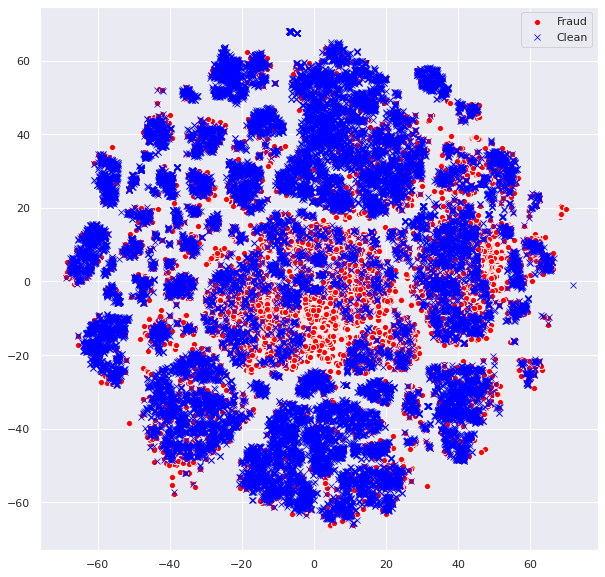

In [75]:
y_ = y.to_numpy()
plt.figure(figsize=(10,10))
sns.scatterplot(x=X_[y_==1, 0], y=X_[y_==1, 1], color='red', marker='o', label='Fraud')
sns.scatterplot(x=X_[y_==0, 0], y=X_[y_==0, 1], color='blue', marker='x', label='Clean')
plt.legend()

## Feature interaction

In [166]:
import hytests
from importlib import reload
reload(hytests)
from hytests import Hypot

In [167]:
X_ = X.copy()

In [168]:
X_[['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain']] = X_[['ProductCD', 'card4', 'card6', 'P_emaildomain','R_emaildomain']].apply(LabelEncoder().fit_transform)
X_[[f'M{i}' for i in range(1,10)]] = X_[[f'M{i}' for i in range(1,10)]].apply(LabelEncoder().fit_transform)

In [169]:
variance_filter = VarianceThreshold(threshold=0)
variance_filter.fit(X_)

VarianceThreshold(threshold=0)

In [170]:
constant_columns = [column for column in X_.columns if column not in X_.columns[variance_filter.get_support()]]
constant_columns

['M1', 'V1', 'V305']

In [171]:
tester = Hypot()

mapping = {'TransactionAmt': 'cont', 'ProductCD': 'cat', 'card1': 'cont', 'card2': 'cont', 'card3': 'cont', 'card4': 'cat', 'card5': 'cont', 'card6': 'cat'}
mapping.update({f'C{i}': 'cont' for i in range(1,15)})
mapping.update({f'M{i}': 'cat' for i in range(1,10)})
mapping.update({f'D{i}': 'cont' for i in range(1,16)})
mapping.update({'addr1': 'cont', 'addr2': 'cont', 'dist1': 'cont', 'dist2': 'cont', 'P_emaildomain': 'cat', 'R_emaildomain': 'cat'})
mapping.update({f'V{i}': 'cont' for i in range(1, 340)})

del mapping['M1']
del mapping['V1']
del mapping['V305']


In [174]:
p = tester.test(data=X_, mapping=mapping)

In [175]:
p

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,C1,C2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionAmt,1.00000,0.0,0.63840,0.00000,0.00000,0.00000,0.00005,0.00000,0.00000,0.00000,...,0.33398,0.57279,0.88054,0.90620,0.08611,0.28214,0.12987,0.00000,0.01704,0.00025
ProductCD,0.00000,1.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
card1,0.63840,0.0,1.00000,0.68847,0.00000,0.00000,0.00000,0.00000,0.60785,0.87690,...,0.00000,0.00000,0.00000,0.00000,0.43209,0.46166,0.90988,0.00002,0.00000,0.00000
card2,0.00000,0.0,0.68847,1.00000,0.00000,0.00000,0.00000,0.00000,0.30633,0.25074,...,0.00012,0.00027,0.00028,0.00012,0.53792,0.40178,0.41361,0.00023,0.00002,0.00001
card3,0.00000,0.0,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.84883,0.96029,0.96205,0.96566,0.99814,0.96606,0.97284,0.60800,0.84348,0.73546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V335,0.28214,0.0,0.46166,0.40178,0.96606,0.00000,0.00000,0.01277,0.69363,0.68787,...,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000
V336,0.12987,0.0,0.90988,0.41361,0.97284,0.00000,0.00004,0.23398,0.79025,0.79509,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
V337,0.00000,0.0,0.00002,0.00023,0.60800,0.02141,0.00000,0.02395,0.63033,0.68326,...,0.00000,0.00000,0.00000,0.00000,0.10001,0.00000,0.00000,1.00000,0.00000,0.00000
V338,0.01704,0.0,0.00000,0.00002,0.84348,0.00000,0.00000,0.00000,0.76581,0.71693,...,0.00000,0.00000,0.00000,0.00000,0.01857,0.00000,0.00000,0.00000,1.00000,0.00000


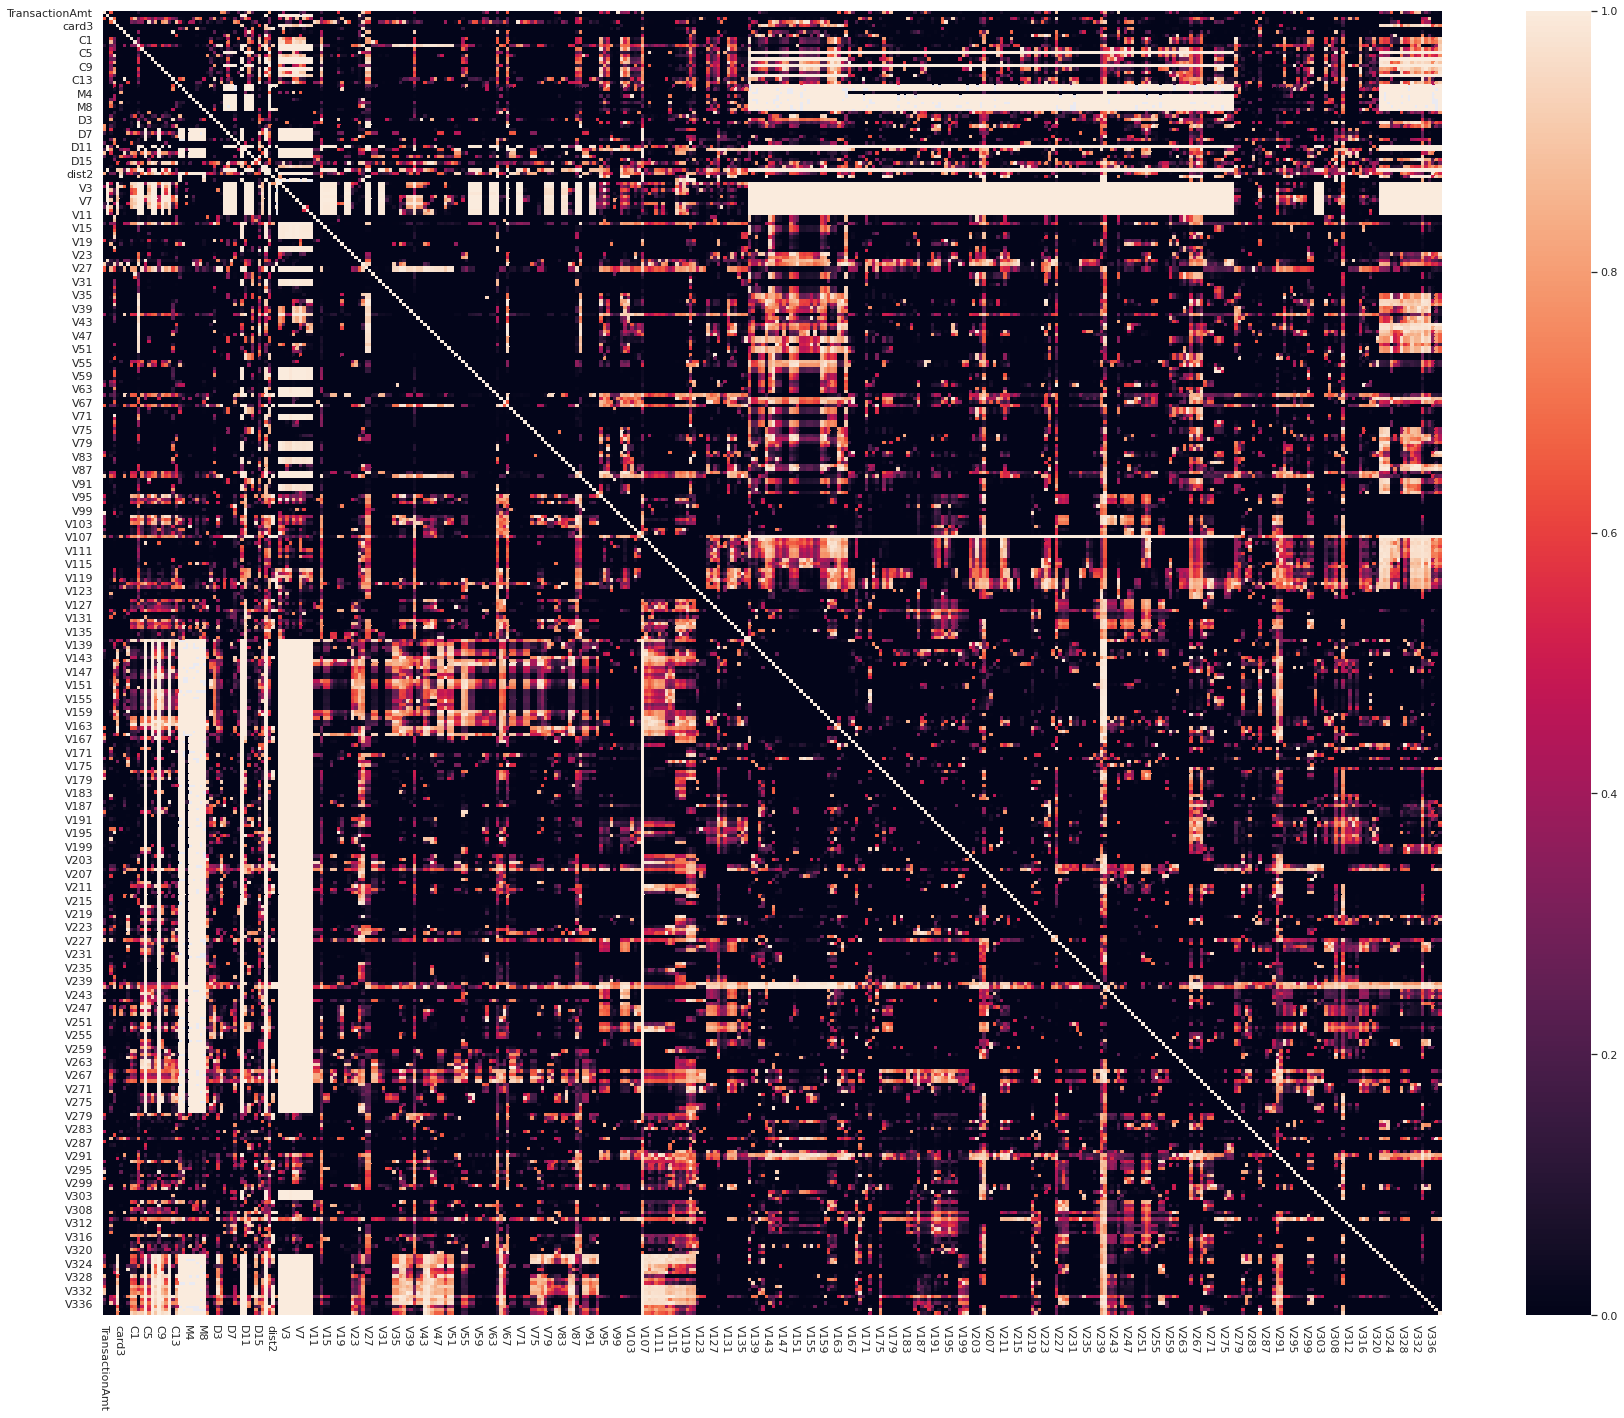

In [185]:
plt.figure(figsize=(30,24))
sns.heatmap(data=p, vmin=0, vmax=1)
plt.yticks(rotation=0)
plt.xticks(rotation=270)
plt.show()

# Modeling

## Base Dataset

In [41]:
X_base = X.copy()

In [42]:
X_base = X_base[['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'ProductCD', 'card4', 'card6']]

In [44]:
X_p = X_base[y==1]
X_n = X_base[y==0]

<AxesSubplot:xlabel='card6', ylabel='count'>

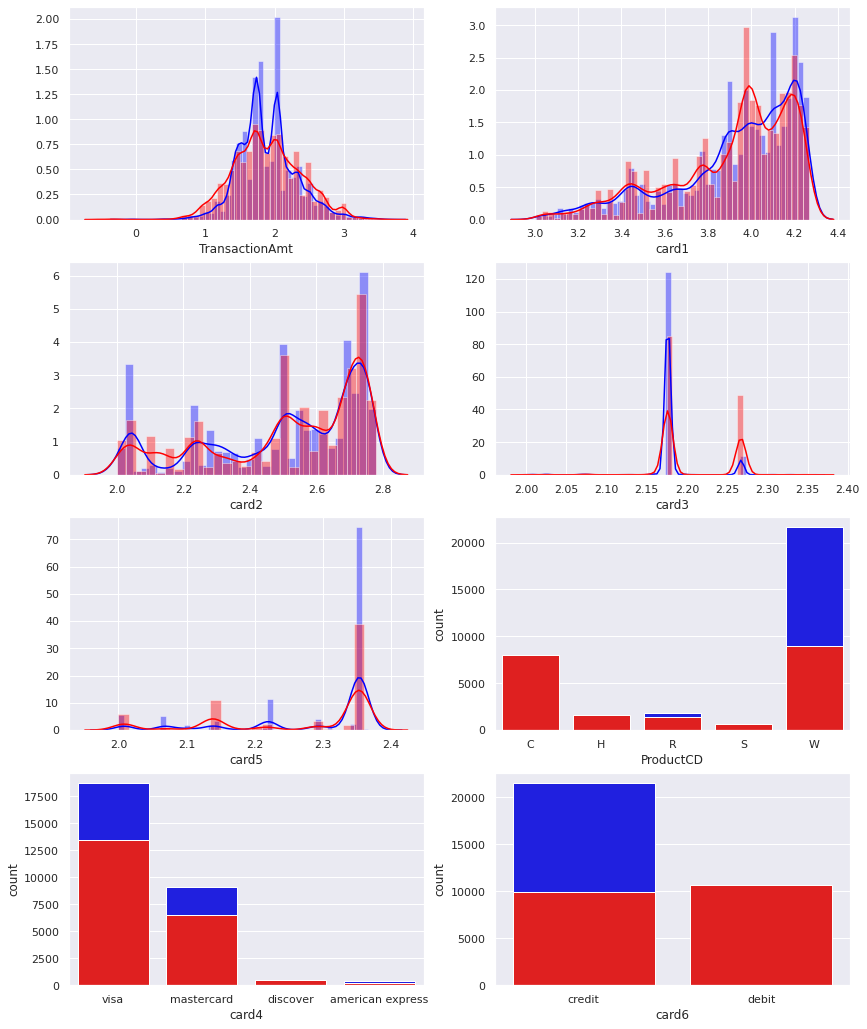

In [45]:
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(14,18))
sns.distplot(a=numpy.log10(X_n['TransactionAmt']), ax=ax[0,0], color='blue')
sns.distplot(a=numpy.log10(X_p['TransactionAmt']), ax=ax[0,0], color='red')
sns.distplot(a=numpy.log10(X_n['card1']), ax=ax[0,1], color='blue')
sns.distplot(a=numpy.log10(X_p['card1']), ax=ax[0,1], color='red')
sns.distplot(a=numpy.log10(X_n['card2']), ax=ax[1,0], color='blue')
sns.distplot(a=numpy.log10(X_p['card2']), ax=ax[1,0], color='red')
sns.distplot(a=numpy.log10(X_n['card3']), ax=ax[1,1], color='blue')
sns.distplot(a=numpy.log10(X_p['card3']), ax=ax[1,1], color='red')
sns.distplot(a=numpy.log10(X_n['card5']), ax=ax[2,0], color='blue')
sns.distplot(a=numpy.log10(X_p['card5']), ax=ax[2,0], color='red')
sns.countplot(x='ProductCD', data=X_n, ax=ax[2,1], color='blue')
sns.countplot(x='ProductCD', data=X_p, ax=ax[2,1], color='red')
sns.countplot(x='card4', data=X_n, ax=ax[3,0], color='blue')
sns.countplot(x='card4', data=X_p, ax=ax[3,0], color='red')
sns.countplot(x='card6', data=X_n, ax=ax[3,1], color='blue')
sns.countplot(x='card6', data=X_p, ax=ax[3,1], color='red')

## Baseline Model

In [52]:
X_ = pandas.get_dummies(X_base, columns=['card4', 'card6', 'ProductCD'], drop_first=True)

In [53]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,card4_discover,card4_mastercard,card4_visa,card6_credit,card6_debit,card6_debit or credit,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
TransactionID,,,,,,,,,,,,,,,
2987203,445.000000,18268.0,583.0,150.0,226.0,0,0,1,1,0,0,0,0,0,1
2987240,37.098000,13413.0,103.0,185.0,137.0,0,0,1,1,0,0,0,0,0,0
2987243,37.098000,13413.0,103.0,185.0,137.0,0,0,1,1,0,0,0,0,0,0
2987245,37.098000,13413.0,103.0,185.0,137.0,0,0,1,1,0,0,0,0,0,0
2987288,155.520996,16578.0,545.0,185.0,226.0,0,0,1,1,0,0,0,0,0,0


In [54]:
X_[['TransactionAmt','card1', 'card2', 'card3', 'card5']] = numpy.log10(X_[['TransactionAmt','card1', 'card2', 'card3', 'card5']]) 

In [55]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,card4_discover,card4_mastercard,card4_visa,card6_credit,card6_debit,card6_debit or credit,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
TransactionID,,,,,,,,,,,,,,,
2987203,2.648360,4.261691,2.765669,2.176091,2.354108,0,0,1,1,0,0,0,0,0,1
2987240,1.569350,4.127526,2.012837,2.267172,2.136721,0,0,1,1,0,0,0,0,0,0
2987243,1.569350,4.127526,2.012837,2.267172,2.136721,0,0,1,1,0,0,0,0,0,0
2987245,1.569350,4.127526,2.012837,2.267172,2.136721,0,0,1,1,0,0,0,0,0,0
2987288,2.191789,4.219532,2.736397,2.267172,2.354108,0,0,1,1,0,0,0,0,0,0


In [56]:
def ml_pipeline(X, y, n_splits, model, polynomial=False):
    
    X = X.to_numpy()
    y = y.to_numpy().reshape(-1, )
    
    if polynomial:
        pol = PolynomialFeatures(interaction_only=True)
        X = pol.fit_transform(X)
        
    Output = recordtype('Output', ['precision', 'recall', 'f1', 'aucPR', 'aucROC','aucs'])
    output = Output(precision=0, recall=0, f1=0, aucPR=0, aucROC=0, aucs=[])
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    for train_index, test_index in cv.split(X, y):
    
        X_train, X_test, y_train, y_test = X[train_index, :], X[test_index, :], y[train_index], y[test_index]

        model.fit(X=X_train, y=y_train)
        y_pred = model.predict(X_test)
        y_probs = model.predict_proba(X_test)[:, 1]
    
        recall = recall_score(y_true=y_test, y_pred=y_pred)
        precision = precision_score(y_true=y_test, y_pred=y_pred)
        f1 = f1_score(y_true=y_test, y_pred=y_pred)
        precisions, recalls, _ = precision_recall_curve(y_true=y_test, probas_pred=y_probs)
        fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_probs)
        aucROC = roc_auc_score(y_true=y_test, y_score=y_probs)
        aucPR = auc(recalls, precisions)
        
        output.recall += recall
        output.precision += precision
        output.f1 += f1
        output.aucPR += aucPR
        output.aucROC += aucROC
        output.aucs.append(aucPR)
        
        print(f'precision: {precision:0.4f}, recall: {recall:0.4f}, f1: {f1:0.4f}, aucPR: {aucPR:0.4f}, aucROC: {aucROC:0.4f}')
    
    output.recall /= n_splits
    output.precision /= n_splits
    output.f1 /= n_splits
    output.aucPR /= n_splits
    output.aucROC /= n_splits
    
    print(f'Final - precision: {output.precision:0.4f}, recall: {output.recall:0.4f}, f1: {output.f1:0.4f}, aucPR: {output.aucPR:0.4f}, aucROC: {output.aucROC:0.4f}')
    
    return output

In [57]:
model = LogisticRegression(random_state=SEED, n_jobs=JOBS)
lr_base = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.6978, recall: 0.5283, f1: 0.6013, aucPR: 0.6785, aucROC: 0.7432
precision: 0.6855, recall: 0.5399, f1: 0.6041, aucPR: 0.6762, aucROC: 0.7383
precision: 0.6848, recall: 0.5530, f1: 0.6119, aucPR: 0.6817, aucROC: 0.7463
precision: 0.6777, recall: 0.5474, f1: 0.6056, aucPR: 0.6748, aucROC: 0.7477
precision: 0.6675, recall: 0.5295, f1: 0.5906, aucPR: 0.6785, aucROC: 0.7426
precision: 0.6784, recall: 0.5227, f1: 0.5905, aucPR: 0.6829, aucROC: 0.7372
precision: 0.6887, recall: 0.5610, f1: 0.6183, aucPR: 0.6867, aucROC: 0.7527
precision: 0.6794, recall: 0.5426, f1: 0.6033, aucPR: 0.6846, aucROC: 0.7461
precision: 0.6954, recall: 0.5315, f1: 0.6025, aucPR: 0.6863, aucROC: 0.7433
precision: 0.6686, recall: 0.5116, f1: 0.5797, aucPR: 0.6651, aucROC: 0.7344
Final - precision: 0.6824, recall: 0.5368, f1: 0.6008, aucPR: 0.6795, aucROC: 0.7432


## XGBoost

In [58]:
X_ = X_base.copy()

In [59]:
X_[['TransactionAmt', 'card1', 'card2', 'card3', 'card5']] = numpy.log10(X_[['TransactionAmt', 'card1', 'card2', 'card3', 'card5']])
X_[['card4', 'card6', 'ProductCD']] = X_[['card4', 'card6', 'ProductCD']].apply(LabelEncoder().fit_transform)

In [60]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output = model.fit(X_, y)

In [61]:
scores = output.get_booster().get_score(importance_type="gain")

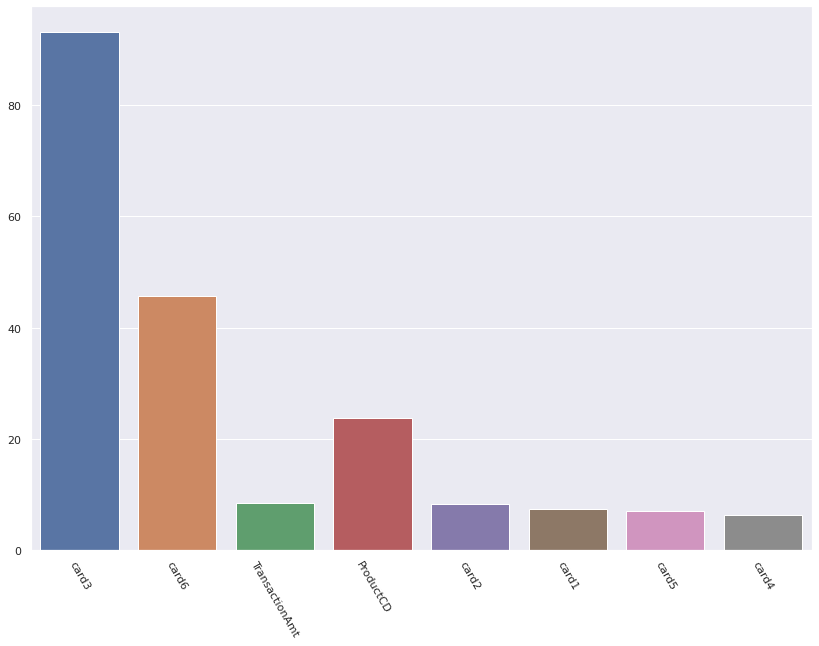

In [62]:
plt.figure(figsize=(14,10))
sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.xticks(rotation=300)
plt.show()

In [63]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_base = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.7686, recall: 0.6507, f1: 0.7047, aucPR: 0.7988, aucROC: 0.8472
precision: 0.7560, recall: 0.6715, f1: 0.7112, aucPR: 0.7877, aucROC: 0.8388
precision: 0.7682, recall: 0.6894, f1: 0.7267, aucPR: 0.8084, aucROC: 0.8567
precision: 0.7580, recall: 0.6791, f1: 0.7164, aucPR: 0.7989, aucROC: 0.8503
precision: 0.7606, recall: 0.6583, f1: 0.7058, aucPR: 0.7980, aucROC: 0.8471
precision: 0.7738, recall: 0.6641, f1: 0.7148, aucPR: 0.8052, aucROC: 0.8486
precision: 0.7426, recall: 0.6718, f1: 0.7055, aucPR: 0.7932, aucROC: 0.8415
precision: 0.7587, recall: 0.6772, f1: 0.7156, aucPR: 0.8087, aucROC: 0.8498
precision: 0.7635, recall: 0.6578, f1: 0.7067, aucPR: 0.8103, aucROC: 0.8520
precision: 0.7501, recall: 0.6583, f1: 0.7012, aucPR: 0.7906, aucROC: 0.8418
Final - precision: 0.7600, recall: 0.6678, f1: 0.7109, aucPR: 0.8000, aucROC: 0.8474


In [276]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_poly = ml_pipeline(X=X_, y=y, n_splits=10, model=model, polynomial=True)

precision: 0.7560, recall: 0.6730, f1: 0.7121, aucPR: 0.7999, aucROC: 0.8475
precision: 0.7539, recall: 0.6715, f1: 0.7103, aucPR: 0.7897, aucROC: 0.8428
precision: 0.7636, recall: 0.6812, f1: 0.7200, aucPR: 0.8113, aucROC: 0.8524
precision: 0.7474, recall: 0.6675, f1: 0.7052, aucPR: 0.7906, aucROC: 0.8437
precision: 0.7618, recall: 0.6810, f1: 0.7191, aucPR: 0.7934, aucROC: 0.8472
precision: 0.7531, recall: 0.6554, f1: 0.7008, aucPR: 0.7948, aucROC: 0.8411
precision: 0.7631, recall: 0.6859, f1: 0.7224, aucPR: 0.8046, aucROC: 0.8499
precision: 0.7563, recall: 0.6864, f1: 0.7196, aucPR: 0.7972, aucROC: 0.8457
precision: 0.7746, recall: 0.6820, f1: 0.7254, aucPR: 0.8176, aucROC: 0.8582
precision: 0.7742, recall: 0.6786, f1: 0.7232, aucPR: 0.8123, aucROC: 0.8600
Final - precision: 0.7604, recall: 0.6762, f1: 0.7158, aucPR: 0.8011, aucROC: 0.8489


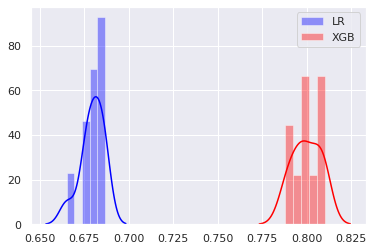

In [64]:
plt.figure()
sns.distplot(lr_base.aucs, color='blue', bins=5, label='LR')
sns.distplot(xgb_base.aucs, color='red', bins=5, label='XGB')
plt.legend()

In [66]:
ttest_rel(lr_base.aucs, xgb_base.aucs)

Ttest_relResult(statistic=-58.54539731951585, pvalue=6.2341455658683e-13)

## Feature Expansion

### C features

In [72]:
C = X.loc[:, 'C1':'C14']

In [73]:
C_p = C[y==1]
C_n = C[y==0]

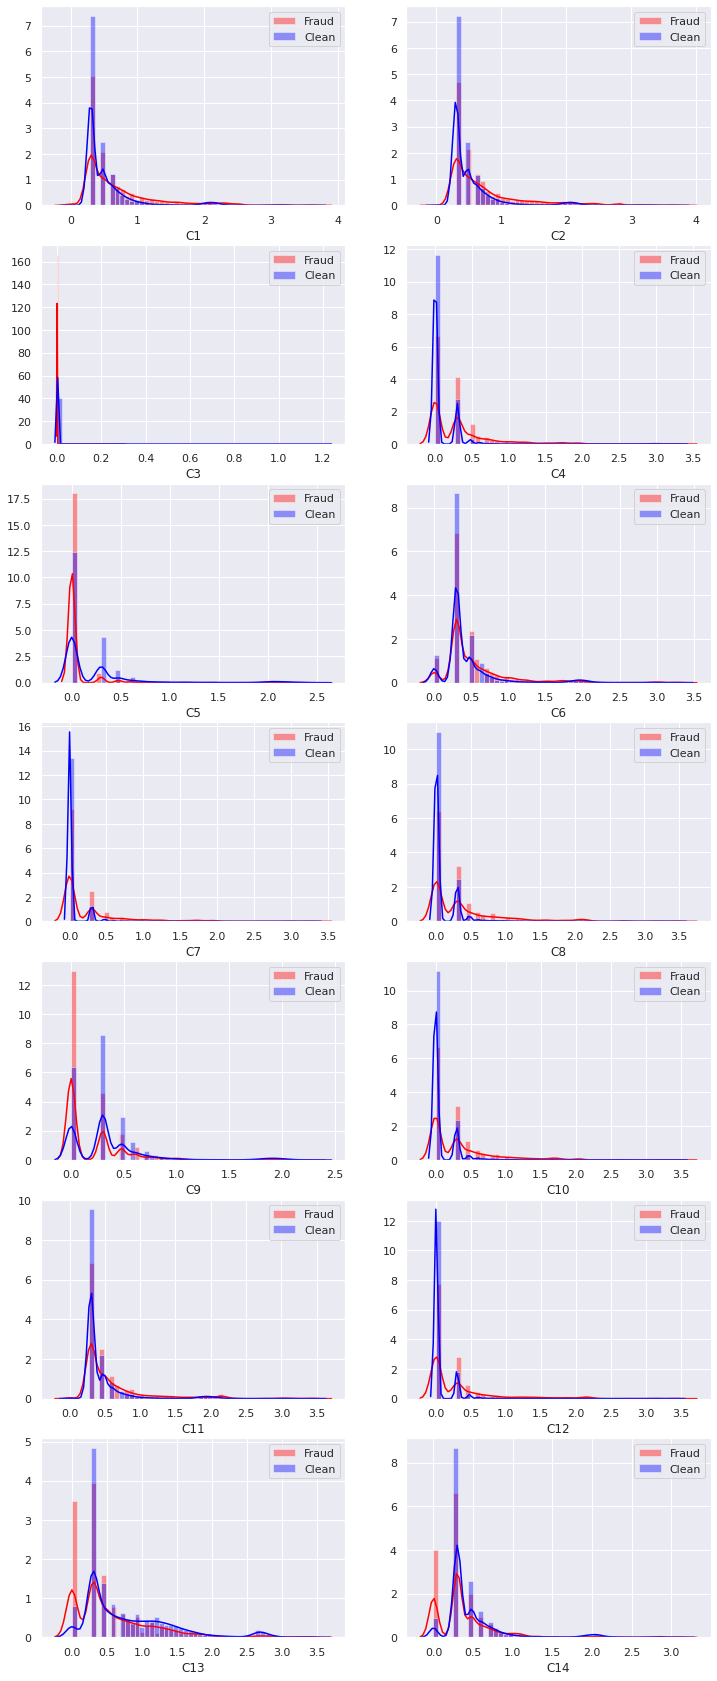

In [74]:

f, ax = plt.subplots(nrows=7, ncols=2, figsize=(12,30))

feature = 1
for row in range(0, 7):
    for col in range(0, 2):
        sns.distplot(numpy.log10(C_p[f'C{feature}'].add(1)), color='red', ax=ax[row,col], label='Fraud')
        sns.distplot(numpy.log10(C_n[f'C{feature}'].add(1)), color='blue', ax=ax[row,col], label='Clean')
        ax[row,col].legend()
        feature += 1
    

In [75]:
XC = X_base.join(C, how='inner')

In [76]:
XC.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,18268.0,583.0,150.0,226.0,W,visa,credit,2.0,2.0,...,0.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,4.0,2.0
2987240,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2987243,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2987245,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,2.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2987288,155.520996,16578.0,545.0,185.0,226.0,C,visa,credit,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0


In [85]:
X_ = XC.copy()

In [86]:
X_[['TransactionAmt', 'card1', 'card2', 'card3', 'card5']] = numpy.log10(XC[['TransactionAmt', 'card1', 'card2', 'card3', 'card5']])
X_.loc[:, 'C1':'C14'] = numpy.log10(XC.loc[:, 'C1':'C14'].add(1))
X_[['card4', 'card6', 'ProductCD']] = X_[['card4', 'card6', 'ProductCD']].apply(LabelEncoder().fit_transform)

In [87]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output = model.fit(X_, y)

In [88]:
scores = output.get_booster().get_score(importance_type="gain")

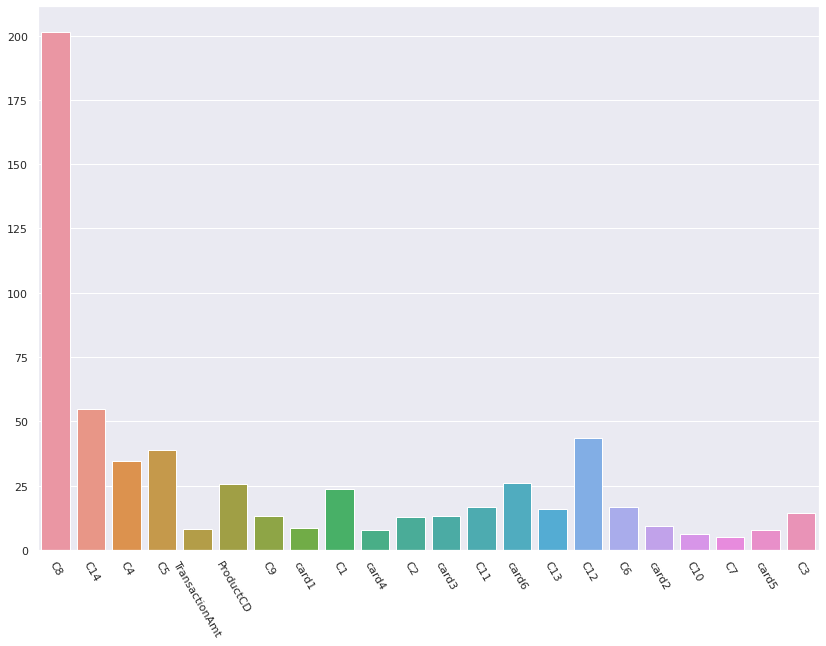

In [89]:
plt.figure(figsize=(14,10))
sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.xticks(rotation=300)
plt.show()

In [90]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.648360,4.261691,2.765669,2.176091,2.354108,4,3,1,0.477121,0.477121,...,0.0,0.477121,0.00000,0.00000,0.477121,0.00000,0.30103,0.00000,0.69897,0.477121
2987240,1.569350,4.127526,2.012837,2.267172,2.136721,0,3,1,0.000000,0.301030,...,0.0,0.301030,0.30103,0.30103,0.000000,0.30103,0.30103,0.30103,0.00000,0.000000
2987243,1.569350,4.127526,2.012837,2.267172,2.136721,0,3,1,0.301030,0.301030,...,0.0,0.301030,0.30103,0.30103,0.000000,0.30103,0.30103,0.30103,0.00000,0.000000
2987245,1.569350,4.127526,2.012837,2.267172,2.136721,0,3,1,0.477121,0.301030,...,0.0,0.301030,0.30103,0.30103,0.000000,0.30103,0.30103,0.30103,0.00000,0.000000
2987288,2.191789,4.219532,2.736397,2.267172,2.354108,0,3,1,0.301030,0.301030,...,0.0,0.301030,0.30103,0.30103,0.000000,0.30103,0.30103,0.30103,0.00000,0.000000


In [91]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_c = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.8655, recall: 0.7625, f1: 0.8107, aucPR: 0.9134, aucROC: 0.9255
precision: 0.8574, recall: 0.7770, f1: 0.8152, aucPR: 0.9103, aucROC: 0.9216
precision: 0.8678, recall: 0.7847, f1: 0.8242, aucPR: 0.9210, aucROC: 0.9310
precision: 0.8697, recall: 0.7885, f1: 0.8271, aucPR: 0.9223, aucROC: 0.9342
precision: 0.8446, recall: 0.7841, f1: 0.8133, aucPR: 0.9081, aucROC: 0.9224
precision: 0.8574, recall: 0.7740, f1: 0.8135, aucPR: 0.9101, aucROC: 0.9214
precision: 0.8634, recall: 0.7619, f1: 0.8095, aucPR: 0.9116, aucROC: 0.9223
precision: 0.8699, recall: 0.7638, f1: 0.8134, aucPR: 0.9163, aucROC: 0.9288
precision: 0.8708, recall: 0.7570, f1: 0.8099, aucPR: 0.9134, aucROC: 0.9238
precision: 0.8558, recall: 0.7643, f1: 0.8075, aucPR: 0.9080, aucROC: 0.9201
Final - precision: 0.8622, recall: 0.7718, f1: 0.8144, aucPR: 0.9134, aucROC: 0.9251


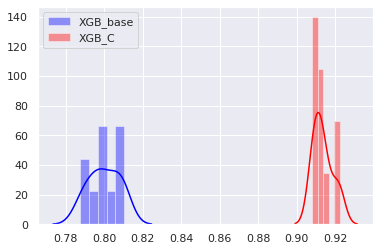

In [92]:
plt.figure()
sns.distplot(xgb_base.aucs, color='blue', bins=5, label='XGB_base')
sns.distplot(xgb_c.aucs, color='red', bins=5, label='XGB_C')
plt.legend()

In [93]:
ttest_rel(xgb_base.aucs, xgb_c.aucs)

Ttest_relResult(statistic=-50.70510565042365, pvalue=2.2656717362036833e-12)

In [94]:
C_sum = X_[[f'C{i}' for i in range(1,15)]].sum(axis=1)

In [95]:
X_['C_sum'] = C_sum
X_.drop(columns=[f'C{i}' for i in range(1,15)], inplace=True)

In [96]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C_sum
TransactionID,,,,,,,,,
2987203,2.648360,4.261691,2.765669,2.176091,2.354108,4,3,1,3.385606
2987240,1.569350,4.127526,2.012837,2.267172,2.136721,0,3,1,2.408240
2987243,1.569350,4.127526,2.012837,2.267172,2.136721,0,3,1,2.709270
2987245,1.569350,4.127526,2.012837,2.267172,2.136721,0,3,1,2.885361
2987288,2.191789,4.219532,2.736397,2.267172,2.354108,0,3,1,2.709270


In [97]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output_xgb = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.8177, recall: 0.6942, f1: 0.7509, aucPR: 0.8531, aucROC: 0.8830
precision: 0.7990, recall: 0.7155, f1: 0.7550, aucPR: 0.8449, aucROC: 0.8740
precision: 0.8156, recall: 0.7063, f1: 0.7571, aucPR: 0.8653, aucROC: 0.8904
precision: 0.8177, recall: 0.7120, f1: 0.7612, aucPR: 0.8649, aucROC: 0.8925
precision: 0.8062, recall: 0.7106, f1: 0.7553, aucPR: 0.8522, aucROC: 0.8820
precision: 0.8144, recall: 0.6902, f1: 0.7472, aucPR: 0.8507, aucROC: 0.8774
precision: 0.8069, recall: 0.7018, f1: 0.7507, aucPR: 0.8519, aucROC: 0.8794
precision: 0.8126, recall: 0.6970, f1: 0.7504, aucPR: 0.8567, aucROC: 0.8823
precision: 0.8224, recall: 0.7014, f1: 0.7571, aucPR: 0.8590, aucROC: 0.8870
precision: 0.7999, recall: 0.6888, f1: 0.7402, aucPR: 0.8450, aucROC: 0.8700
Final - precision: 0.8112, recall: 0.7018, f1: 0.7525, aucPR: 0.8544, aucROC: 0.8818


### Adress features

In [110]:
G = X[['addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain']]

In [111]:
G.head()

,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
TransactionID,,,,,,
2987203,251.000000,87.000000,134.04924,216.759171,aol.com,gmail.com
2987240,291.550537,86.615471,134.04924,216.759171,hotmail.com,hotmail.com
2987243,291.550537,86.615471,134.04924,216.759171,hotmail.com,hotmail.com
2987245,291.550537,86.615471,134.04924,216.759171,hotmail.com,hotmail.com
2987288,291.550537,86.615471,134.04924,216.759171,outlook.com,outlook.com


In [112]:
G_p = G[y==1]
G_n = G[y==0]

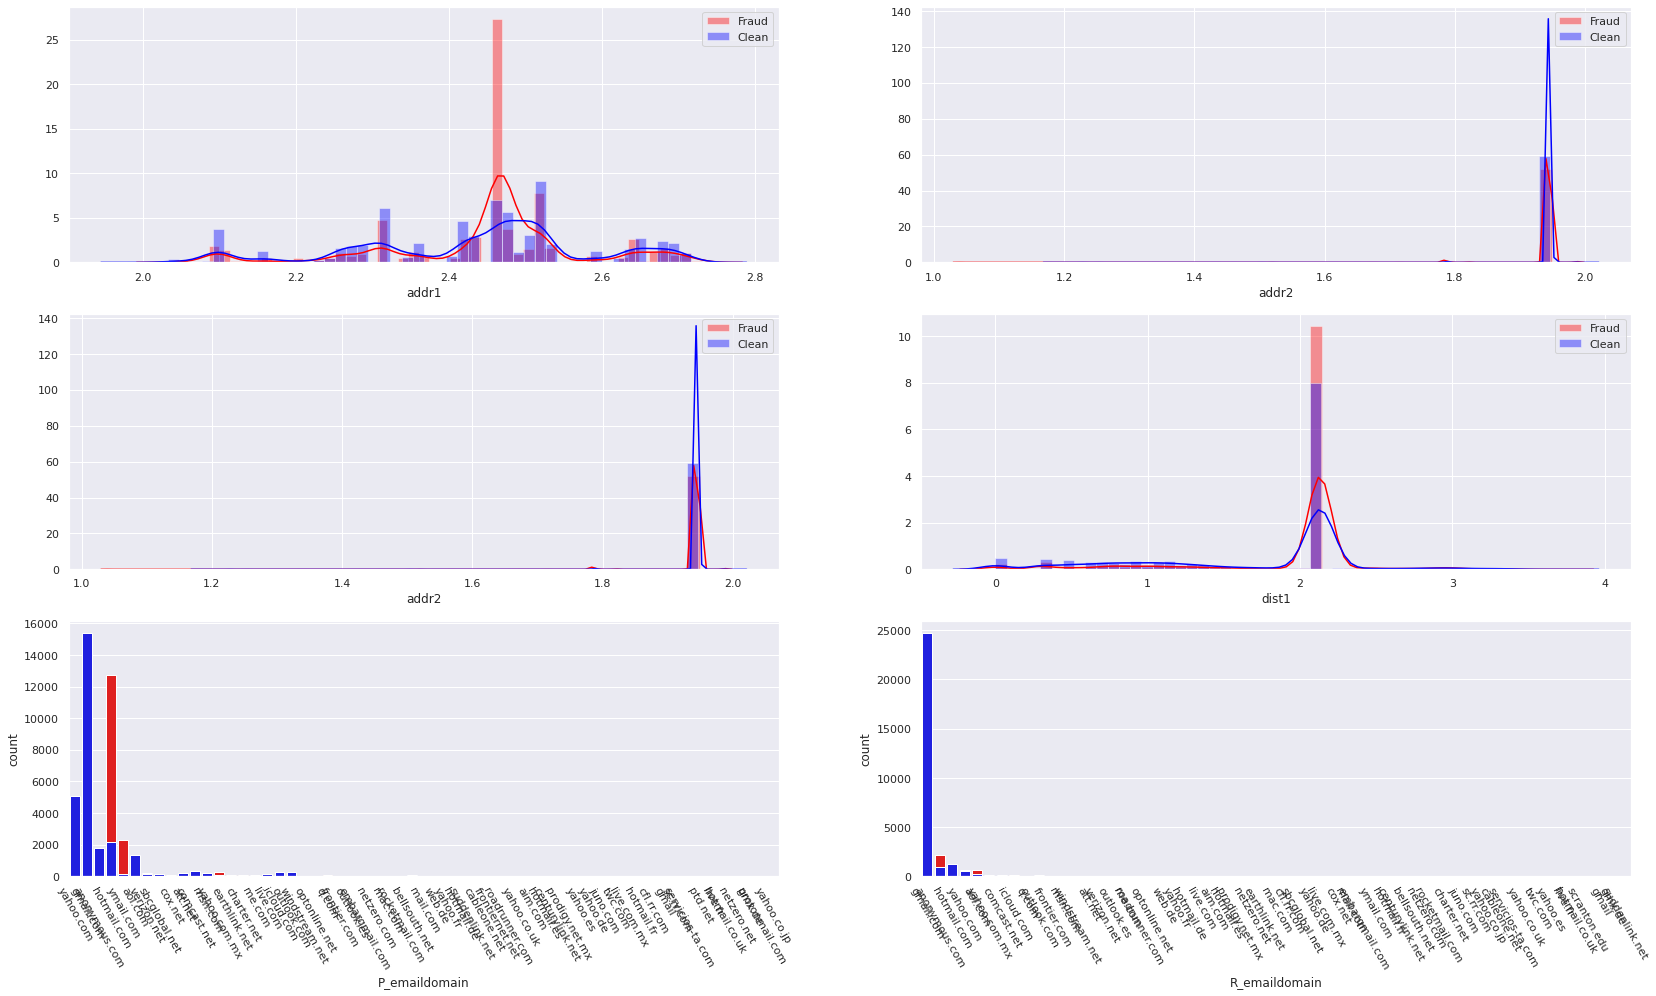

In [113]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(28,16))

features = ['addr1', 'addr2', 'dist1', 'dist2']
for row in range(0, 2):
    for col in range(0, 2):
        sns.distplot(numpy.log10(G_p[features[row+col]].add(1)), color='red', ax=ax[row,col], label='Fraud')
        sns.distplot(numpy.log10(G_n[features[row+col]].add(1)), color='blue', ax=ax[row,col], label='Clean')
        ax[row,col].legend()
        
sns.countplot(G_p['P_emaildomain'], color='red', ax=ax[2, 0], label='Fraud')
sns.countplot(G_n['P_emaildomain'], color='blue', ax=ax[2, 0], label='Clean')
sns.countplot(G_p['R_emaildomain'], color='red', ax=ax[2, 1], label='Fraud')
sns.countplot(G_n['R_emaildomain'], color='blue', ax=ax[2, 1], label='Clean')
ax[2,1].tick_params(axis='x', labelrotation=300)
ax[2,0].tick_params(axis='x', labelrotation=300)
plt.show()

In [114]:
XCG = XC.join(G, how='inner')

In [115]:
XCG.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,C11,C12,C13,C14,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,18268.0,583.0,150.0,226.0,W,visa,credit,2.0,2.0,...,1.0,0.0,4.0,2.0,251.000000,87.000000,134.04924,216.759171,aol.com,gmail.com
2987240,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,0.0,1.0,...,1.0,1.0,0.0,0.0,291.550537,86.615471,134.04924,216.759171,hotmail.com,hotmail.com
2987243,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,1.0,1.0,...,1.0,1.0,0.0,0.0,291.550537,86.615471,134.04924,216.759171,hotmail.com,hotmail.com
2987245,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,2.0,1.0,...,1.0,1.0,0.0,0.0,291.550537,86.615471,134.04924,216.759171,hotmail.com,hotmail.com
2987288,155.520996,16578.0,545.0,185.0,226.0,C,visa,credit,1.0,1.0,...,1.0,1.0,0.0,0.0,291.550537,86.615471,134.04924,216.759171,outlook.com,outlook.com


In [116]:
X_ = XCG.copy()

In [117]:
X_[['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'dist1', 'dist2']] = numpy.log10(X_[['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'dist1', 'dist2']].add(1))
X_.loc[:, 'C1':'C14'] = numpy.log10(X_.loc[:, 'C1':'C14'].add(1))
X_[['card4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain']] = X_[['card4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain']].apply(LabelEncoder().fit_transform)

In [118]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,C11,C12,C13,C14,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.649335,4.261715,2.766413,2.178977,2.356026,4,3,1,0.477121,0.477121,...,0.30103,0.00000,0.69897,0.477121,251.000000,87.000000,2.130492,2.337976,2,15
2987240,1.580902,4.127558,2.017033,2.269513,2.139879,0,3,1,0.000000,0.301030,...,0.30103,0.30103,0.00000,0.000000,291.550537,86.615471,2.130492,2.337976,19,18
2987243,1.580902,4.127558,2.017033,2.269513,2.139879,0,3,1,0.301030,0.301030,...,0.30103,0.30103,0.00000,0.000000,291.550537,86.615471,2.130492,2.337976,19,18
2987245,1.580902,4.127558,2.017033,2.269513,2.139879,0,3,1,0.477121,0.301030,...,0.30103,0.30103,0.00000,0.000000,291.550537,86.615471,2.130492,2.337976,19,18
2987288,2.194573,4.219558,2.737193,2.269513,2.356026,0,3,1,0.301030,0.301030,...,0.30103,0.30103,0.00000,0.000000,291.550537,86.615471,2.130492,2.337976,35,34


In [119]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output = model.fit(X_, y)

In [120]:
scores = output.get_booster().get_score(importance_type="gain")

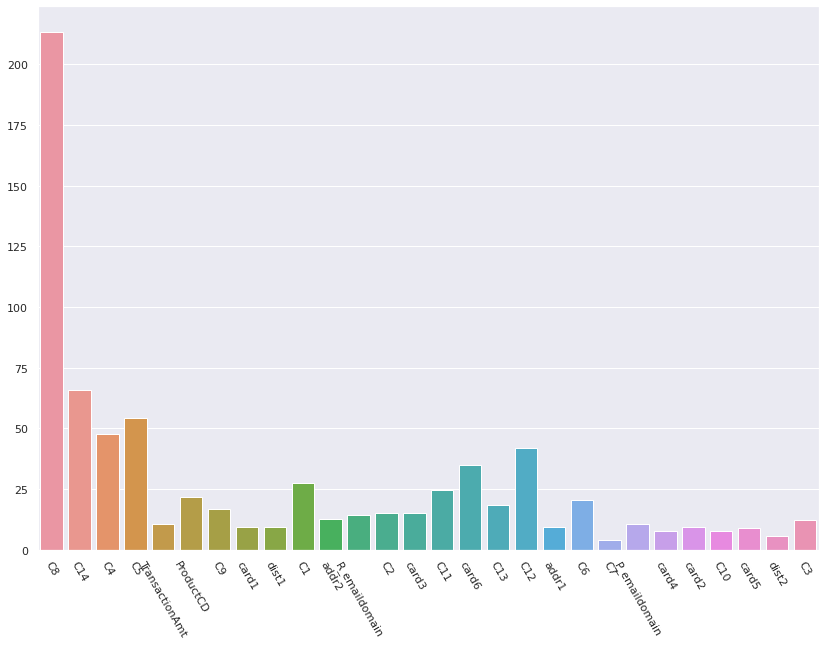

In [121]:
plt.figure(figsize=(14,10))
sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.xticks(rotation=300)
plt.show()

In [122]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_cg = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.8766, recall: 0.7804, f1: 0.8257, aucPR: 0.9224, aucROC: 0.9336
precision: 0.8718, recall: 0.7896, f1: 0.8286, aucPR: 0.9189, aucROC: 0.9287
precision: 0.8882, recall: 0.7954, f1: 0.8392, aucPR: 0.9324, aucROC: 0.9418
precision: 0.8844, recall: 0.8035, f1: 0.8420, aucPR: 0.9301, aucROC: 0.9420
precision: 0.8522, recall: 0.7899, f1: 0.8199, aucPR: 0.9162, aucROC: 0.9303
precision: 0.8621, recall: 0.7870, f1: 0.8229, aucPR: 0.9161, aucROC: 0.9274
precision: 0.8746, recall: 0.7865, f1: 0.8282, aucPR: 0.9228, aucROC: 0.9328
precision: 0.8858, recall: 0.7924, f1: 0.8365, aucPR: 0.9225, aucROC: 0.9347
precision: 0.8771, recall: 0.7875, f1: 0.8299, aucPR: 0.9213, aucROC: 0.9327
precision: 0.8664, recall: 0.7691, f1: 0.8149, aucPR: 0.9169, aucROC: 0.9284
Final - precision: 0.8739, recall: 0.7881, f1: 0.8288, aucPR: 0.9220, aucROC: 0.9332


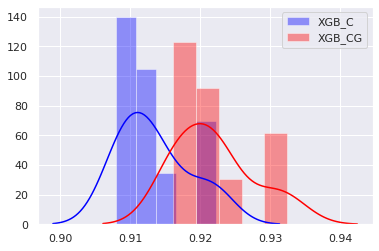

In [123]:
plt.figure()
sns.distplot(xgb_c.aucs, color='blue', bins=5, label='XGB_C')
sns.distplot(xgb_cg.aucs, color='red', bins=5, label='XGB_CG')
plt.legend()

In [124]:
ttest_rel(xgb_cg.aucs, xgb_c.aucs)

Ttest_relResult(statistic=15.140146411914376, pvalue=1.0405416117334552e-07)

### M features

In [126]:
features = [f'M{i}' for i in range(1,10)]

In [127]:
M = X.loc[:, features]

In [128]:
M.head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,
2987203,T,T,T,M0,F,T,F,F,T
2987240,T,T,T,M2,F,F,F,F,T
2987243,T,T,T,M2,F,F,F,F,T
2987245,T,T,T,M2,F,F,F,F,T
2987288,T,T,T,M2,F,F,F,F,T


In [131]:
M_p = M[y==1]
M_n = M[y==0]

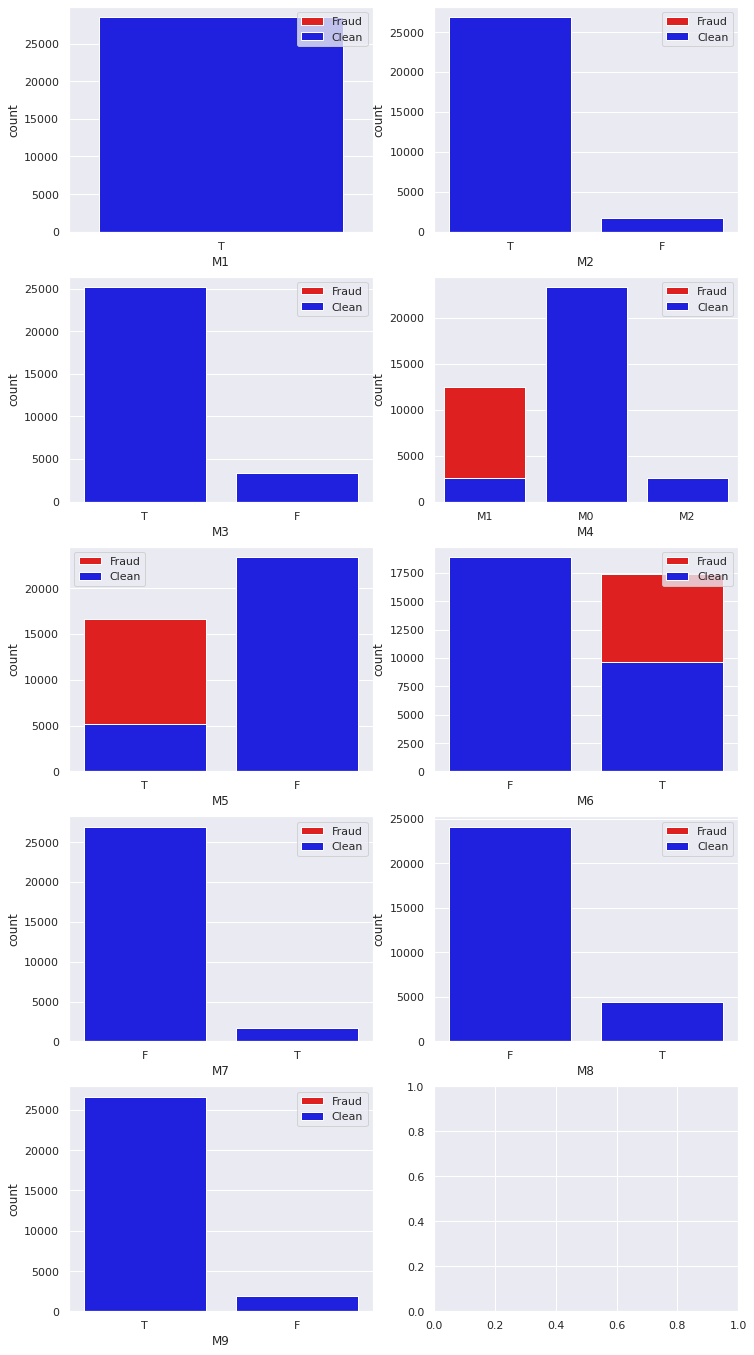

In [132]:
f, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 24))

feature = 1
for row in range(0, 5):
    for col in range(0, 2):
        if feature < 10:
            sns.countplot(M_p[f'M{feature}'], color='red', ax=ax[row,col], label='Fraud')
            sns.countplot(M_n[f'M{feature}'], color='blue', ax=ax[row,col], label='Clean')
            ax[row,col].legend()
            feature += 1


In [133]:
XCGM = XCG.join(M, how='inner')

In [134]:
XCGM.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,18268.0,583.0,150.0,226.0,W,visa,credit,2.0,2.0,...,gmail.com,T,T,T,M0,F,T,F,F,T
2987240,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,0.0,1.0,...,hotmail.com,T,T,T,M2,F,F,F,F,T
2987243,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,1.0,1.0,...,hotmail.com,T,T,T,M2,F,F,F,F,T
2987245,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,2.0,1.0,...,hotmail.com,T,T,T,M2,F,F,F,F,T
2987288,155.520996,16578.0,545.0,185.0,226.0,C,visa,credit,1.0,1.0,...,outlook.com,T,T,T,M2,F,F,F,F,T


In [136]:
X_ = XCGM.copy()

In [137]:
X_[['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'dist1', 'dist2']] = numpy.log10(X_[['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'dist1', 'dist2']].add(1))
X_.loc[:, 'C1':'C14'] = numpy.log10(X_.loc[:, 'C1':'C14'].add(1))
X_[['card4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain']] = X_[['card4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain']].apply(LabelEncoder().fit_transform)
X_[features] = X_[features].apply(LabelEncoder().fit_transform)

In [138]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.649335,4.261715,2.766413,2.178977,2.356026,4,3,1,0.477121,0.477121,...,15,0,1,1,0,0,1,0,0,1
2987240,1.580902,4.127558,2.017033,2.269513,2.139879,0,3,1,0.000000,0.301030,...,18,0,1,1,2,0,0,0,0,1
2987243,1.580902,4.127558,2.017033,2.269513,2.139879,0,3,1,0.301030,0.301030,...,18,0,1,1,2,0,0,0,0,1
2987245,1.580902,4.127558,2.017033,2.269513,2.139879,0,3,1,0.477121,0.301030,...,18,0,1,1,2,0,0,0,0,1
2987288,2.194573,4.219558,2.737193,2.269513,2.356026,0,3,1,0.301030,0.301030,...,34,0,1,1,2,0,0,0,0,1


In [139]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output = model.fit(X_, y)

In [140]:
scores = output.get_booster().get_score(importance_type="gain")

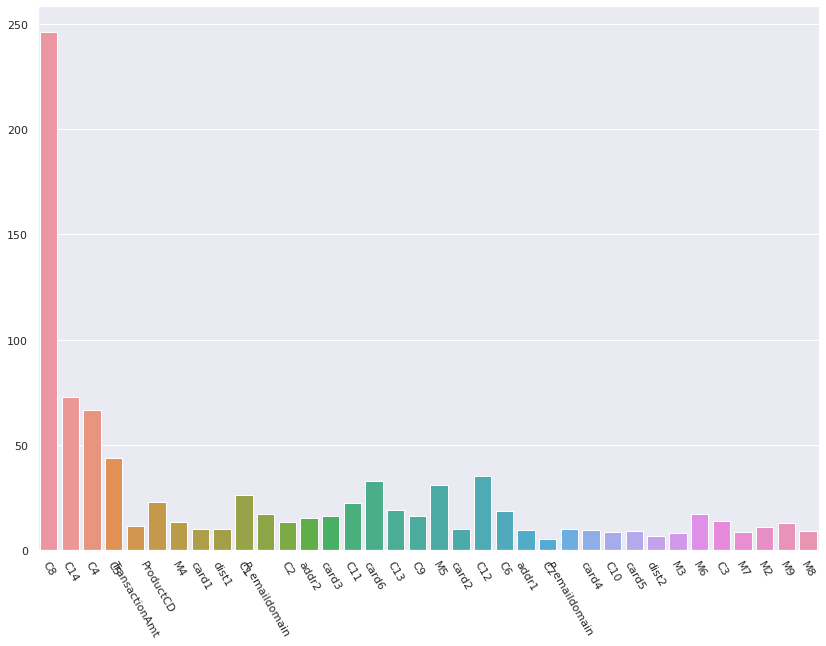

In [141]:
plt.figure(figsize=(14,10))
sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.xticks(rotation=300)
plt.show()

In [142]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_cgm = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.8819, recall: 0.7910, f1: 0.8340, aucPR: 0.9248, aucROC: 0.9358
precision: 0.8714, recall: 0.7934, f1: 0.8306, aucPR: 0.9223, aucROC: 0.9323
precision: 0.8897, recall: 0.8075, f1: 0.8466, aucPR: 0.9344, aucROC: 0.9430
precision: 0.8805, recall: 0.8132, f1: 0.8455, aucPR: 0.9330, aucROC: 0.9441
precision: 0.8595, recall: 0.8083, f1: 0.8331, aucPR: 0.9176, aucROC: 0.9327
precision: 0.8694, recall: 0.7894, f1: 0.8275, aucPR: 0.9210, aucROC: 0.9319
precision: 0.8733, recall: 0.7875, f1: 0.8282, aucPR: 0.9249, aucROC: 0.9340
precision: 0.8870, recall: 0.7938, f1: 0.8378, aucPR: 0.9268, aucROC: 0.9379
precision: 0.8775, recall: 0.7943, f1: 0.8338, aucPR: 0.9259, aucROC: 0.9379
precision: 0.8628, recall: 0.7793, f1: 0.8189, aucPR: 0.9181, aucROC: 0.9288
Final - precision: 0.8753, recall: 0.7958, f1: 0.8336, aucPR: 0.9249, aucROC: 0.9358


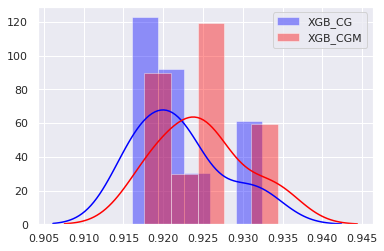

In [143]:
plt.figure()
sns.distplot(xgb_cg.aucs, color='blue', bins=5, label='XGB_CG')
sns.distplot(xgb_cgm.aucs, color='red', bins=5, label='XGB_CGM')
plt.legend()

In [144]:
ttest_rel(xgb_cgm.aucs, xgb_cg.aucs)

Ttest_relResult(statistic=6.991106278810238, pvalue=6.387168551408083e-05)

### D features

In [160]:
features = [f'D{i}' for i in range(1,16)]

In [161]:
D = X.loc[:, features]

In [162]:
D.head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
TransactionID,,,,,,,,,,,,,,,
2987203,57.0,57.000000,52.000000,0.0,30.698406,54.462791,20.078215,81.548767,0.533472,80.0,130.490662,46.77314,10.20713,55.410862,374.0
2987240,0.0,141.396637,22.350887,0.0,30.698406,0.000000,20.078215,45.041664,0.041666,0.0,130.490662,0.00000,0.00000,0.000000,0.0
2987243,0.0,141.396637,22.350887,0.0,0.000000,0.000000,0.000000,45.041664,0.041666,0.0,130.490662,0.00000,0.00000,0.000000,0.0
2987245,0.0,141.396637,22.350887,0.0,0.000000,0.000000,0.000000,45.041664,0.041666,0.0,130.490662,0.00000,0.00000,0.000000,0.0
2987288,0.0,141.396637,22.350887,0.0,30.698406,0.000000,20.078215,81.548767,0.533472,0.0,130.490662,0.00000,0.00000,0.000000,0.0


In [163]:
D_p = D[y==1]
D_n = D[y==0]

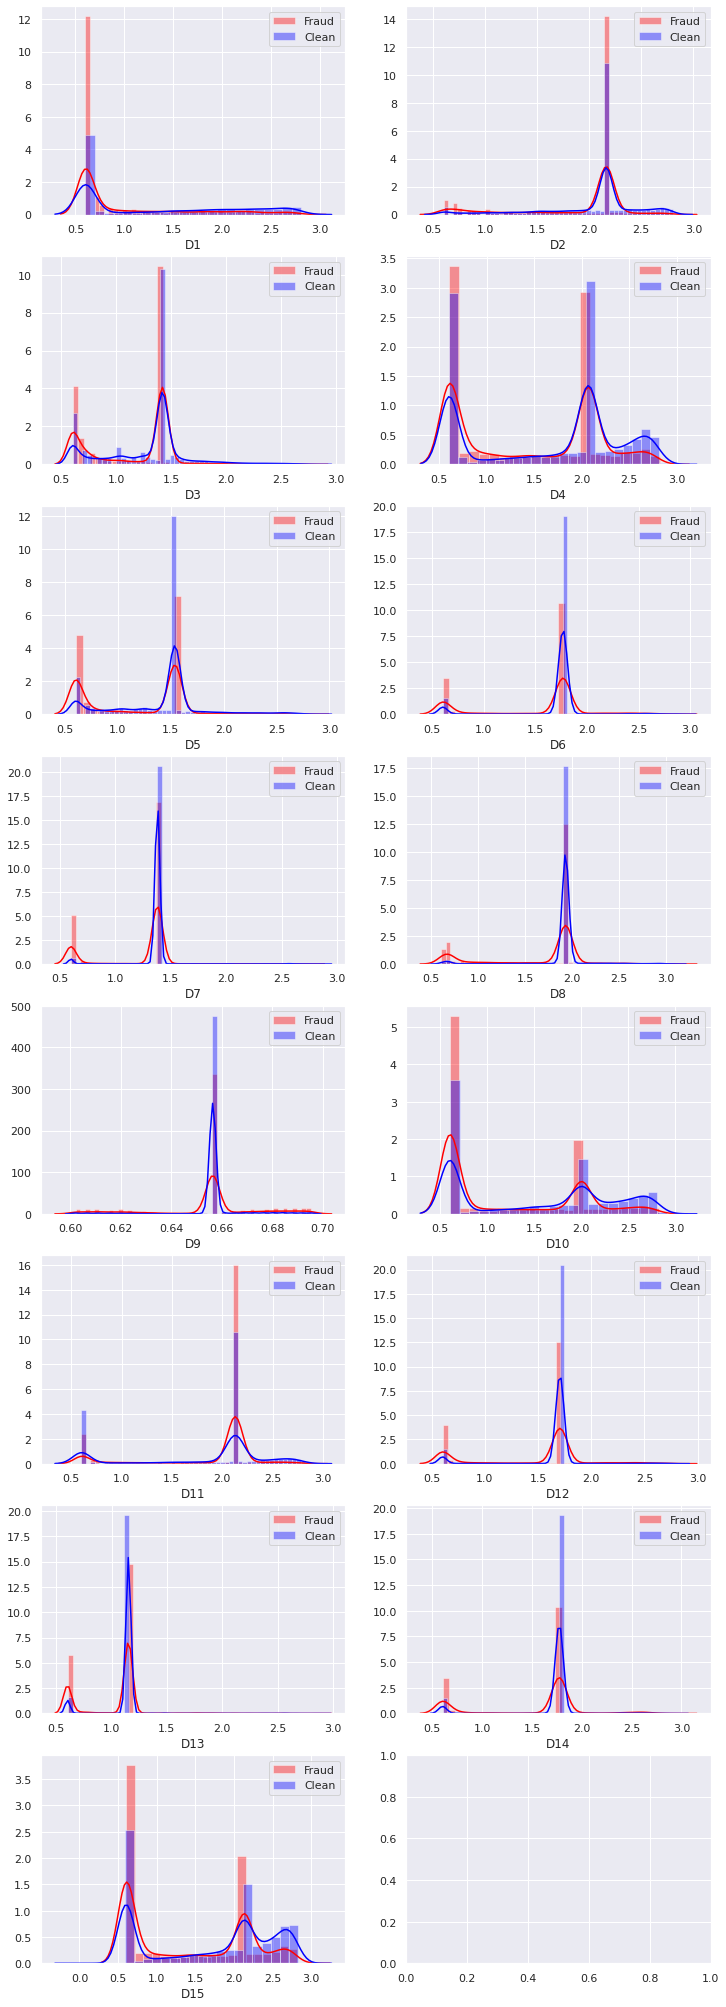

In [165]:
f, ax = plt.subplots(nrows=8, ncols=2, figsize=(12, 36))

feature = 1
for row in range(0, 8):
    for col in range(0, 2):
        if feature < 16:
            sns.distplot(numpy.log10(D_p[f'D{feature}'].add(4)), color='red', ax=ax[row,col], label='Fraud')
            sns.distplot(numpy.log10(D_n[f'D{feature}'].add(4)), color='blue', ax=ax[row,col], label='Clean')
            ax[row,col].legend()
            feature += 1

In [166]:
XCGMD = XCGM.join(D, how='inner')

In [167]:
XCGMD.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,18268.0,583.0,150.0,226.0,W,visa,credit,2.0,2.0,...,54.462791,20.078215,81.548767,0.533472,80.0,130.490662,46.77314,10.20713,55.410862,374.0
2987240,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,0.0,1.0,...,0.000000,20.078215,45.041664,0.041666,0.0,130.490662,0.00000,0.00000,0.000000,0.0
2987243,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,1.0,1.0,...,0.000000,0.000000,45.041664,0.041666,0.0,130.490662,0.00000,0.00000,0.000000,0.0
2987245,37.098000,13413.0,103.0,185.0,137.0,C,visa,credit,2.0,1.0,...,0.000000,0.000000,45.041664,0.041666,0.0,130.490662,0.00000,0.00000,0.000000,0.0
2987288,155.520996,16578.0,545.0,185.0,226.0,C,visa,credit,1.0,1.0,...,0.000000,20.078215,81.548767,0.533472,0.0,130.490662,0.00000,0.00000,0.000000,0.0


In [169]:
X_ = XCGMD.copy()

In [170]:
X_[['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'dist1', 'dist2']] = numpy.log10(X_[['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'dist1', 'dist2']].add(1))
X_.loc[:, 'C1':'C14'] = numpy.log10(X_.loc[:, 'C1':'C14'].add(1))
X_[['card4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain']] = X_[['card4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain']].apply(LabelEncoder().fit_transform)
X_.loc[:, 'M1':'M9'] = X_.loc[:, 'M1':'M9'].apply(LabelEncoder().fit_transform)
X_.loc[:, 'D1':'D15'] = numpy.log10(X_.loc[:, 'D1':'D15'].add(4))

In [171]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,ProductCD,card4,card6,C1,C2,...,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.649335,4.261715,2.766413,2.178977,2.356026,4,3,1,0.477121,0.477121,...,1.76688,1.381624,1.932214,0.656431,1.924279,2.128692,1.705634,1.152506,1.773866,2.577492
2987240,1.580902,4.127558,2.017033,2.269513,2.139879,0,3,1,0.000000,0.301030,...,0.60206,1.381624,1.690565,0.606560,0.602060,2.128692,0.602060,0.602060,0.602060,0.602060
2987243,1.580902,4.127558,2.017033,2.269513,2.139879,0,3,1,0.301030,0.301030,...,0.60206,0.602060,1.690565,0.606560,0.602060,2.128692,0.602060,0.602060,0.602060,0.602060
2987245,1.580902,4.127558,2.017033,2.269513,2.139879,0,3,1,0.477121,0.301030,...,0.60206,0.602060,1.690565,0.606560,0.602060,2.128692,0.602060,0.602060,0.602060,0.602060
2987288,2.194573,4.219558,2.737193,2.269513,2.356026,0,3,1,0.301030,0.301030,...,0.60206,1.381624,1.932214,0.656431,0.602060,2.128692,0.602060,0.602060,0.602060,0.602060


In [172]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output = model.fit(X_, y)

In [173]:
scores = output.get_booster().get_score(importance_type="gain")

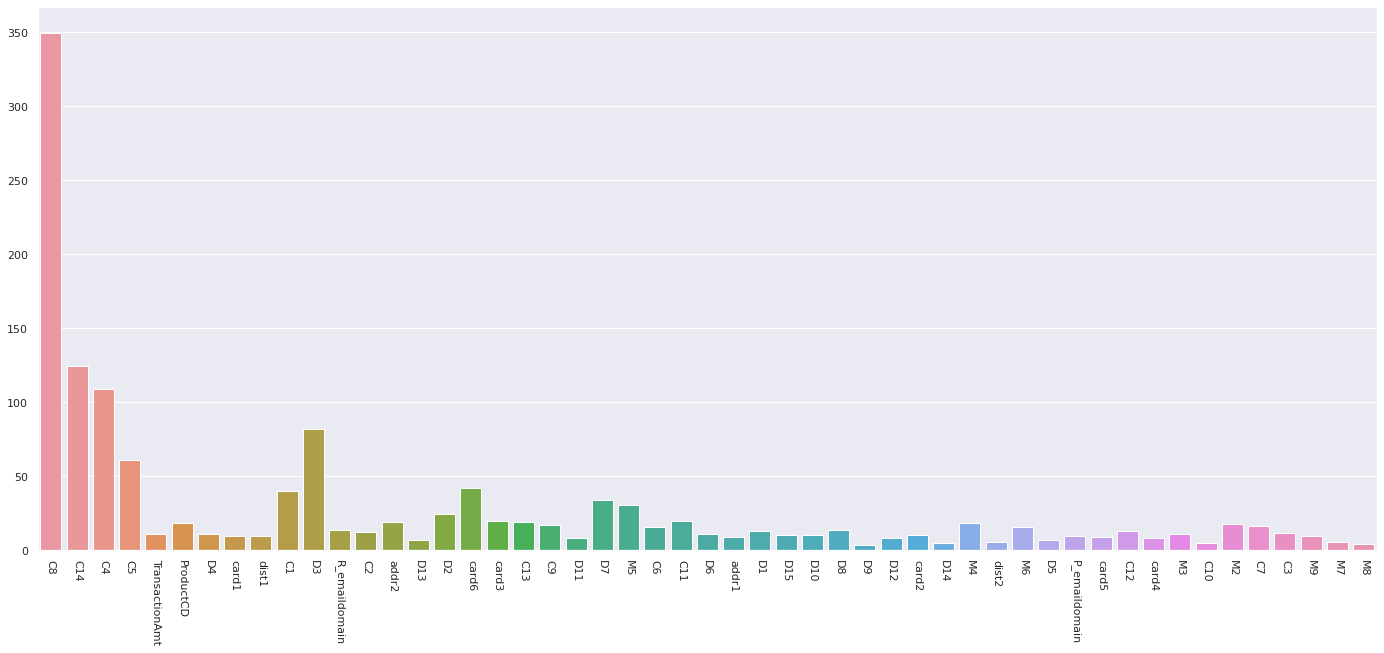

In [177]:
plt.figure(figsize=(24,10))
sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.xticks(rotation=270)
plt.show()

In [178]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_cgmd = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.8759, recall: 0.8094, f1: 0.8413, aucPR: 0.9277, aucROC: 0.9379
precision: 0.8869, recall: 0.8118, f1: 0.8477, aucPR: 0.9321, aucROC: 0.9405
precision: 0.8850, recall: 0.8113, f1: 0.8465, aucPR: 0.9354, aucROC: 0.9437
precision: 0.8878, recall: 0.8272, f1: 0.8564, aucPR: 0.9375, aucROC: 0.9474
precision: 0.8514, recall: 0.8180, f1: 0.8344, aucPR: 0.9216, aucROC: 0.9352
precision: 0.8752, recall: 0.8011, f1: 0.8365, aucPR: 0.9237, aucROC: 0.9320
precision: 0.8830, recall: 0.8001, f1: 0.8395, aucPR: 0.9282, aucROC: 0.9361
precision: 0.8832, recall: 0.8161, f1: 0.8483, aucPR: 0.9364, aucROC: 0.9458
precision: 0.8958, recall: 0.8238, f1: 0.8583, aucPR: 0.9343, aucROC: 0.9448
precision: 0.8653, recall: 0.8083, f1: 0.8358, aucPR: 0.9246, aucROC: 0.9352
Final - precision: 0.8789, recall: 0.8127, f1: 0.8445, aucPR: 0.9301, aucROC: 0.9399


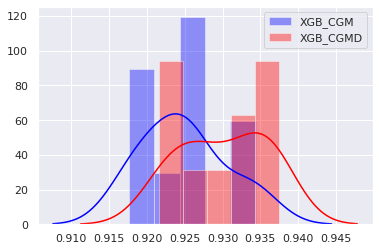

In [180]:
plt.figure()
sns.distplot(xgb_cgm.aucs, color='blue', bins=5, label='XGB_CGM')
sns.distplot(xgb_cgmd.aucs, color='red', bins=5, label='XGB_CGMD')
plt.legend()

In [181]:
ttest_rel(xgb_cgmd.aucs, xgb_cgm.aucs)

Ttest_relResult(statistic=5.3597787702481785, pvalue=0.0004564466289389991)